## Artificial Neural Networks - Binary Classification

### Tensorflow Logging

The code below disables the warning logging from the TensorFlow.

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Declaration of Functions

The section below presents all the functions used in the notebook.

In [2]:
# Function: Read the dataset and return a dataframe
import pandas as pd

def read_data(dataset):
    # Number of rows in each dataframe
    chunksize = 500000
    
    # List that will contain all the dataframes
    list_of_dataframes = []
    
    for df in pd.read_csv(dataset, chunksize=chunksize):
        list_of_dataframes.append(df)
        
    df = pd.concat(list_of_dataframes)
    print(f'[DONE] Dataset imported with success')
    return df

### Importing Testing & Training Datasets

The datasets are the following (<mark>both are saved under the directory Saved Datasets</mark>):
- Training_Binary.pkl
- Testing_Binary.pkl

In [3]:
# Import dataset and read the data into a dataframe
DATASET = '../../../Datasets/IP-Based/IP-Based Alter Dataset.csv'
df = read_data(DATASET)
x_columns = df.columns.drop(['attack_type', 'is_malicious'])

[DONE] Dataset imported with success


In [4]:
import pickle as pkl
import os

FILENAME_DATASET = 'Dataset_Binary.pkl'
FILENAME_TESTING = 'Testing_Binary.pkl'
FILENAME_TRAINING = 'Training_Binary.pkl'
FILENAME_VALIDATION = 'Validation_Binary.pkl'
DIRECTORY = 'Saved Datasets'

dataset_training = os.path.join(DIRECTORY, FILENAME_TRAINING)
dataset_testing = os.path.join(DIRECTORY, FILENAME_TESTING)
dataset_validation = os.path.join(DIRECTORY, FILENAME_VALIDATION)
dataset = os.path.join(DIRECTORY, FILENAME_DATASET)

# Loading Dataset 
with open(dataset, 'rb') as f:
    x, y = pkl.load(f)
print(f'[GENERAL] Dataset Loaded')

# Loading Train Fraction 
with open(dataset_training, 'rb') as f:
    x_train, y_train = pkl.load(f)
print(f'[TRAINING] Dataset Loaded')

# Loading Test Fraction 
with open(dataset_testing, 'rb') as f:
    x_test, y_test = pkl.load(f)
print(f'[TESTING] Dataset Loaded')

# Loading Validation Fraction 
with open(dataset_validation, 'rb') as f:
    x_val, y_val = pkl.load(f)
print(f'[VALIDATION] Dataset Loaded')

[GENERAL] Dataset Loaded
[TRAINING] Dataset Loaded
[TESTING] Dataset Loaded
[VALIDATION] Dataset Loaded


### Defining Metrics & Plots

The following sections defines the classification metrics used for the traditional machine learning algorithms used in this notebook. The metrics are:

- Recall
- Precision
- F1-Score


In [5]:
import tensorflow.keras
from tensorflow.keras import backend as K

# Metrics for real-time usage in the model below
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [6]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def conf_matrix(y_test, prediction, array_dimension = 2):
    if (array_dimension == 2):
        predict_classes = np.argmax(prediction, axis = 1)
        expected_classes = np.argmax(y_test, axis = 1)
    elif (array_dimension == 1):
        predict_classes = prediction
        expected_classes = y_test
    
    cm = confusion_matrix(expected_classes, predict_classes)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Malicious'])

    # Plot size
    fig, ax = plt.subplots(figsize=(4,4))
    
    # Add axis labels and rotate them
    ax.set_xlabel('Predicted labels', rotation=0, labelpad=10, fontsize=11)
    ax.set_ylabel('True labels', rotation=90, labelpad=10, fontsize=11)
    
    cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Normal', 'Malicious'])
    ax.set_yticklabels(['Normal', 'Malicious'])
    
    ax.tick_params(axis='x', pad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', va='center')
    ax.tick_params(axis='y', pad=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', va='center')
    
    # Adjust colorbar size
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=11)  # Adjust the font size of colorbar labels
    cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(cmd.im_, cax=cax)    

In [7]:
# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import numpy as np

def extra_tree_classifier(x_train, y_train, x_columns):
    # Usage of ExtraTreesClassifier for feature selection
    extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion = 'entropy', max_features = 2)
    extra_tree_forest.fit(x_train, y_train)
    feature_importances = extra_tree_forest.feature_importances_
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in  extra_tree_forest.estimators_], axis = 0)

    # Plot the feature importances
    plt.rcParams["figure.figsize"] = (70, 40)
    plt.bar(x_columns, feature_importance_normalized, align = 'center')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Importance')
    plt.title('Comparison of different feature importances in the current dataset')
    plt.xticks(rotation = 90)
    plt.show()

### Neural Network Model

This code sets up a neural network model using the TensorFlow and Keras libraries. The model architecture consists of three dense (fully connected) layers. The first layer has 50 units and uses the ReLU activation function, followed by a dropout layer that randomly sets 50% of the inputs to 0 during training to prevent overfitting. The second hidden layer has 25 units and also uses the ReLU activation function, followed by another dropout layer. The final output layer has a number of units equal to the number of classes in the output, and it uses the softmax activation function to produce probabilities for each class.

The model is compiled with the categorical cross-entropy loss function, the Adam optimizer, and a custom metric called f1_m. It then sets up two callbacks for training: EarlyStopping and ReduceLROnPlateau. EarlyStopping monitors the validation loss and stops training if there is no improvement for 10 consecutive epochs, helping prevent overfitting. ReduceLROnPlateau reduces the learning rate by a factor of 0.5 if the validation loss does not improve for 10 consecutive epochs, allowing the model to fine-tune its weights.

The model is trained using the fit() function on the provided training data (x_train and y_train), with validation data (x_test and y_test) used for evaluating the model's performance during training. The ReduceLROnPlateau callback is passed as a parameter to adjust the learning rate dynamically. The training is verbose (prints progress information) and runs for a maximum of 100 epochs.

Finally, the trained model is saved in the 'Saved_Models/Model_Binary.h5' file.

In [8]:
%%time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Neural Network Model
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu')) # Hidden 2
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu')) # Hidden 3
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu')) # Hidden 4 
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid')) # Output

# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m]) 

# Early Stopping
monitor = EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-3, 
    patience=10, 
    verbose=1, 
    mode='auto', 
    restore_best_weights=True
)

# Reduce On Plateau
reduce = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    verbose=1,
    mode='auto',
    min_lr=1e-7
)

# Save the best model
checkpoint = ModelCheckpoint(
    'Saved Models/Model_Binary.h5',
    monitor='val_loss', 
    save_best_only=True
)

# Model
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test), 
    callbacks=[reduce, checkpoint],
    batch_size=512,
    epochs=100
)

Epoch 1/100
1099/1099 [==============================] - 14s 11ms/step - loss: 0.2030 - f1_m: 0.9034 - val_loss: 0.1623 - val_f1_m: 0.9213 - lr: 0.0010
Epoch 2/100
1099/1099 [==============================] - 12s 11ms/step - loss: 0.1728 - f1_m: 0.9171 - val_loss: 0.1608 - val_f1_m: 0.9215 - lr: 0.0010
Epoch 3/100
1099/1099 [==============================] - 12s 11ms/step - loss: 0.1674 - f1_m: 0.9205 - val_loss: 0.1542 - val_f1_m: 0.9235 - lr: 0.0010
Epoch 4/100
1099/1099 [==============================] - 13s 12ms/step - loss: 0.1449 - f1_m: 0.9365 - val_loss: 0.1001 - val_f1_m: 0.9649 - lr: 0.0010
Epoch 5/100
1099/1099 [==============================] - 13s 12ms/step - loss: 0.1132 - f1_m: 0.9606 - val_loss: 0.1070 - val_f1_m: 0.9649 - lr: 0.0010
Epoch 6/100
1099/1099 [==============================] - 14s 12ms/step - loss: 0.1103 - f1_m: 0.9621 - val_loss: 0.0979 - val_f1_m: 0.9649 - lr: 0.0010
Epoch 7/100
1099/1099 [==============================] - 13s 12ms/step - loss: 0.1074 - 

1099/1099 [==============================] - 11s 10ms/step - loss: 0.0486 - f1_m: 0.9857 - val_loss: 0.2225 - val_f1_m: 0.9653 - lr: 0.0010
Epoch 55/100
1099/1099 [==============================] - 12s 10ms/step - loss: 0.0493 - f1_m: 0.9854 - val_loss: 0.0351 - val_f1_m: 0.9952 - lr: 0.0010
Epoch 56/100
1099/1099 [==============================] - 12s 11ms/step - loss: 0.0485 - f1_m: 0.9858 - val_loss: 0.7932 - val_f1_m: 0.8143 - lr: 0.0010
Epoch 57/100
1099/1099 [==============================] - 13s 12ms/step - loss: 0.0478 - f1_m: 0.9858 - val_loss: 0.5394 - val_f1_m: 0.8143 - lr: 0.0010
Epoch 58/100
1099/1099 [==============================] - 13s 12ms/step - loss: 0.0490 - f1_m: 0.9855 - val_loss: 0.2723 - val_f1_m: 0.9649 - lr: 0.0010
Epoch 59/100
1099/1099 [==============================] - 14s 13ms/step - loss: 0.0470 - f1_m: 0.9863 - val_loss: 0.0331 - val_f1_m: 0.9889 - lr: 0.0010
Epoch 60/100
1099/1099 [==============================] - 13s 12ms/step - loss: 0.0465 - f1_m: 

In [9]:
from tensorflow.keras.models import load_model

# Load the best-saved model
model = load_model('Saved Models/Model_Binary.h5', custom_objects={'f1_m':f1_m})

In [10]:
# Output of hyperparameters stats used in model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6144      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

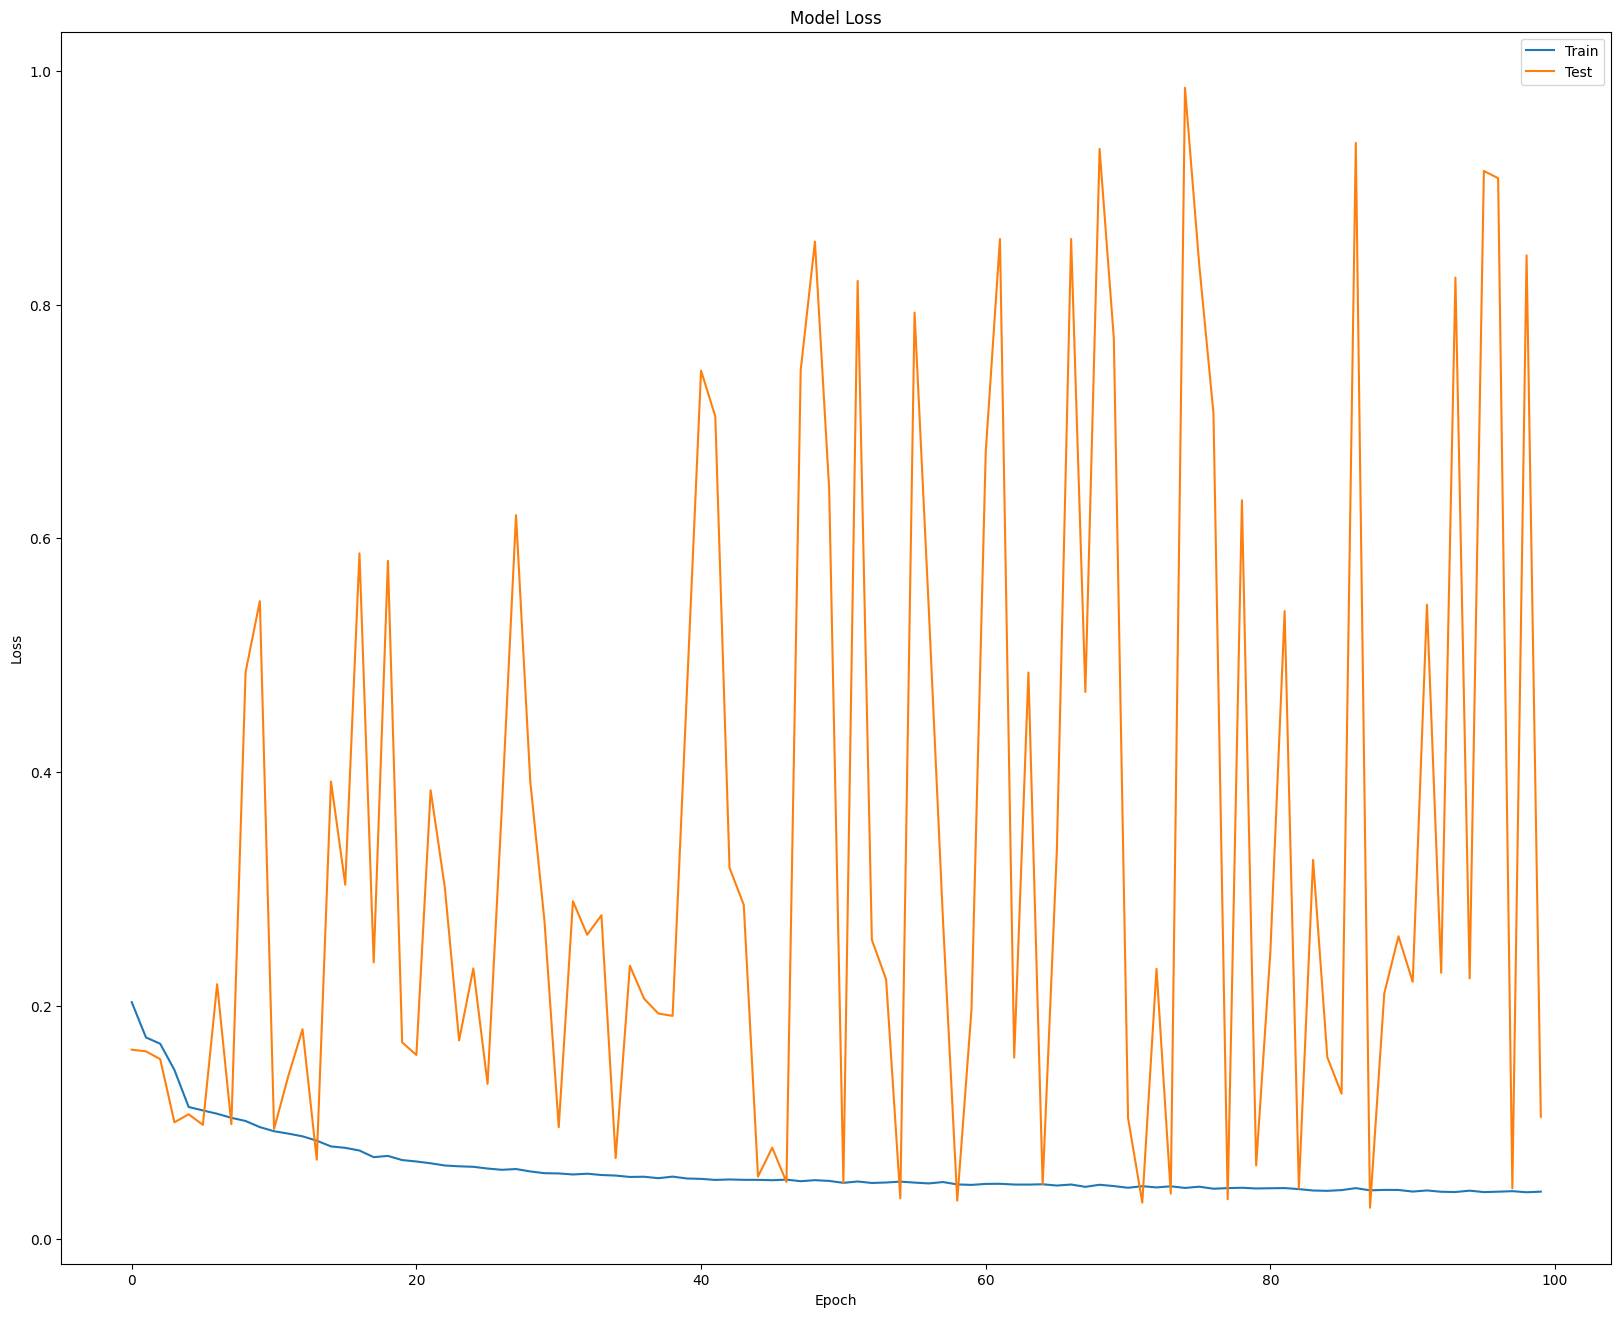

In [11]:
# Model Loss
fig, ax = plt.subplots(figsize=(20, 16))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [12]:
# Prediction
pred = model.predict(x_val)

5860/5860 [==============================] - 7s 1ms/step


In [13]:
from sklearn import metrics

# Metrics for the classification
def compute_metrics(pred, y_val):
    predict_classes = np.argmax(pred, axis = 1)
    expected_classes = np.argmax(y_val, axis = 1)
    
    correct = metrics.accuracy_score(expected_classes, predict_classes)
    print(f"Accuracy: {correct}")
    
    recall = metrics.recall_score(expected_classes, predict_classes, average='weighted')    
    print(f"Recall: {recall}")
       
    precision = metrics.precision_score(expected_classes, predict_classes, average='weighted')
    print(f"Precision: {precision}")
    
    f1score = metrics.f1_score(expected_classes, predict_classes, average='weighted')
    print(f"F1-Score: {f1score}")
    
compute_metrics(pred, y_val)

Accuracy: 0.9928053333333333
Recall: 0.9928053333333333
Precision: 0.992806936524081
F1-Score: 0.9928053091515576


[CMATRIX] DNN Model Confusion Matrix


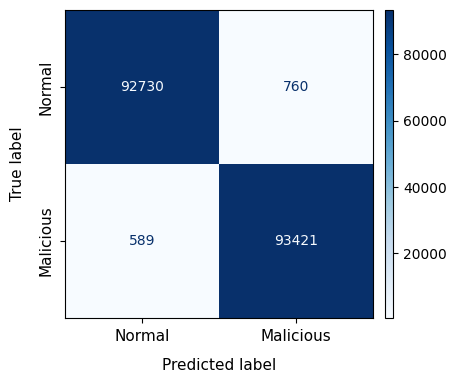

In [14]:
print(f'[CMATRIX] DNN Model Confusion Matrix')
conf_matrix(y_val, pred)

[PLOT] DNN Model Extra Tree Classifier


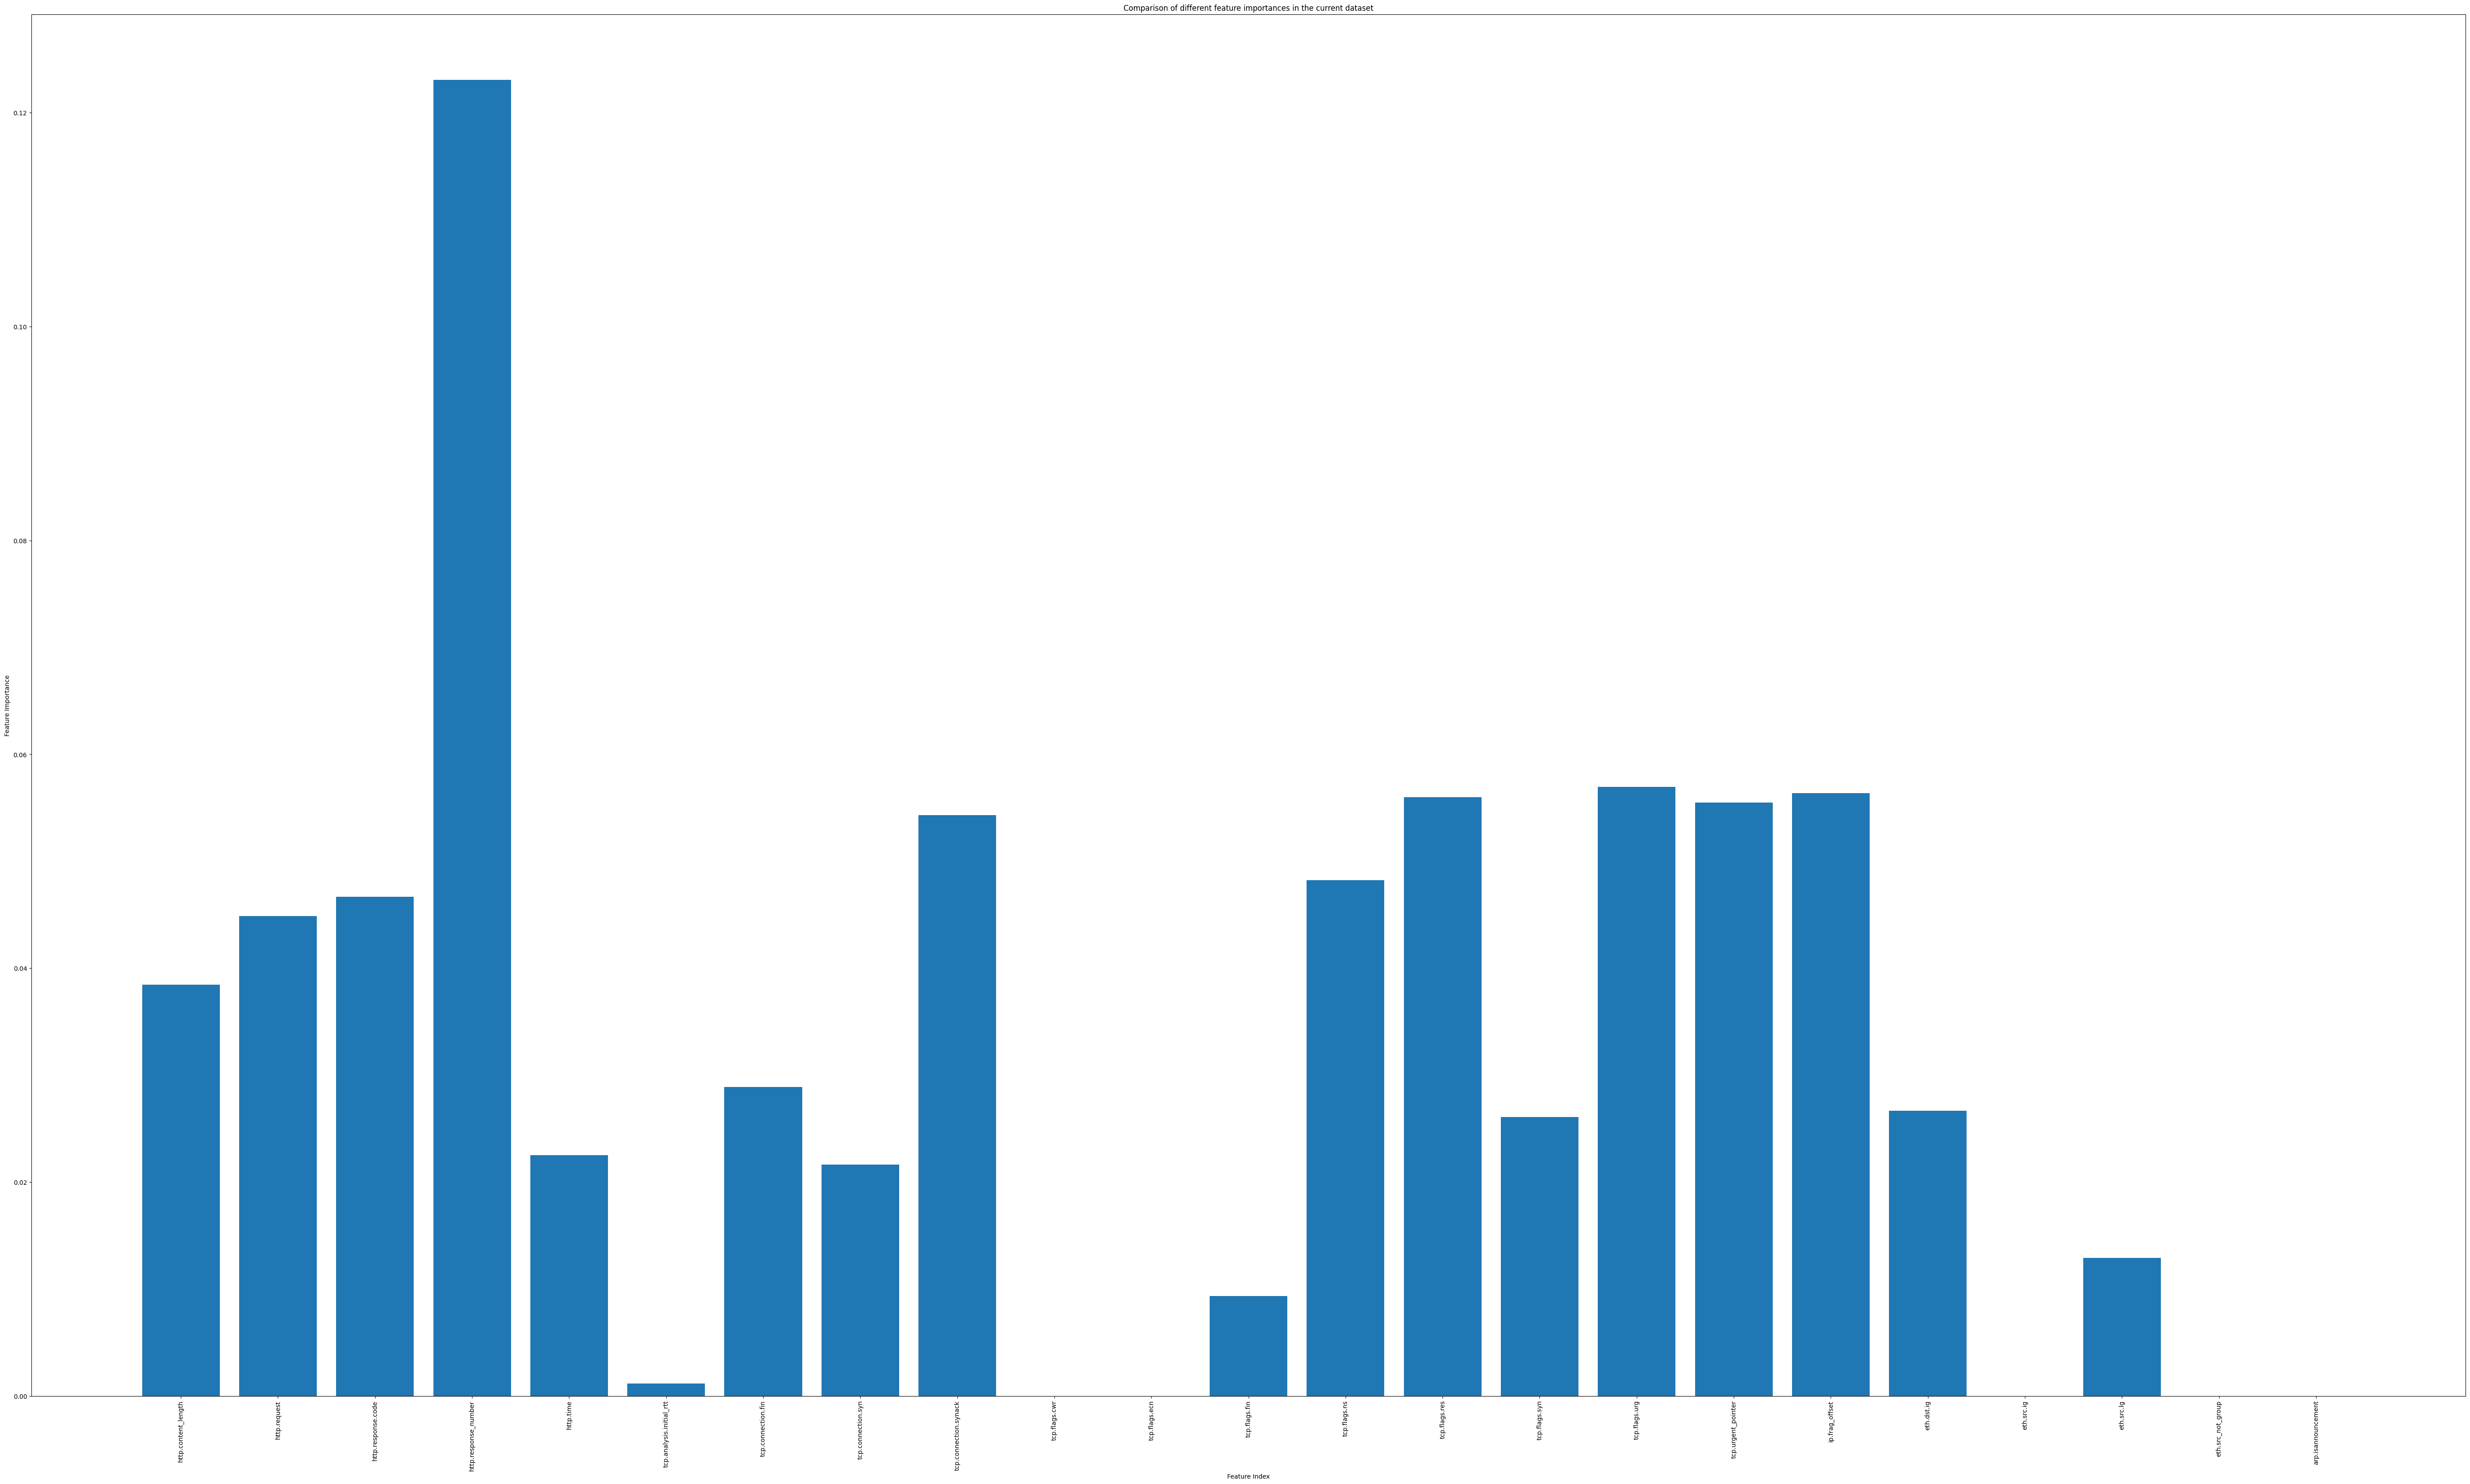

In [15]:
print(f'[PLOT] DNN Model Extra Tree Classifier')
extra_tree_classifier(x, y, x_columns)